## Demo: Stage1 processing for mooring data

Read the original raw files and convert to netCDF. None to minimal additional processing.

This notebook demonstrates the usage of the refactored `oceanarray.stage1_mooring` module.

In [ ]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from pathlib import Path

# Import the refactored stage1 processing module
from oceanarray.stage1 import MooringProcessor, process_multiple_moorings, stage1_mooring

# For testing individual readers (optional)
from ctd_tools.readers import NortekAsciiReader, AdcpMatlabReader
from ctd_tools.plotters import TimeSeriesPlotter

/Users/eddifying/Cloudfree/github/oceanarray/venv/lib/python3.11/site-packages/pycnv/pycnv.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Configuration

Set up the base directory and mooring lists for processing.

In [2]:
# Base directory containing the mooring data
basedir = '/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/'

# Define mooring lists
all_moorings = ['ds2_X_2012', 'ds2_X_2017', 'ds2_X_2018',
                'ds8_1_2012', 'ds9_1_2012', 'ds10_1_2012', 'ds11_1_2012', 'ds12_1_2012',
                'ds13_1_2012', 'ds14_1_2012', 'ds15_1_2012', 'ds16_1_2012', 'ds17_1_2012',
                'ds19_1_2012', 'ds18_1_2012', 'ds28_1_2017',
                'dsA_1_2018', 'dsB_1_2018', 'dsC_1_2018', 'dsD_1_2018', 'dsE_1_2018', 'dsF_1_2018',
                'dsM1_1_2017', 'dsM2_1_2017', 'dsM3_1_2017', 'dsM4_1_2017', 'dsM5_1_2017']

# Subset for testing
test_moorings_2018 = ['dsA_1_2018', 'dsB_1_2018', 'dsC_1_2018', 'dsD_1_2018', 'dsE_1_2018', 'dsF_1_2018']
single_test = ['dsE_1_2018']

# Choose which set to process
moorlist = single_test

print(f"Base directory: {basedir}")
print(f"Processing {len(moorlist)} moorings: {moorlist}")

Base directory: /Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/
Processing 1 moorings: ['dsE_1_2018']


## Processing Moorings

### Option 1: Using the new class-based approach

In [4]:
# Initialize the processor
processor = MooringProcessor(basedir)

# Process each mooring individually with detailed output
results = {}
for mooring_name in moorlist:
    print(f"\n{'='*60}")
    print(f"Processing mooring: {mooring_name}")
    print(f"{'='*60}")

    success = processor.process_mooring(mooring_name)
    results[mooring_name] = success

    status = "✅ SUCCESS" if success else "❌ FAILED"
    print(f"\nResult for {mooring_name}: {status}")

# Print final summary
print(f"\n{'='*60}")
print("FINAL PROCESSING SUMMARY")
print(f"{'='*60}")
successful = sum(results.values())
total = len(results)
print(f"Successfully processed: {successful}/{total} moorings")

for mooring, success in results.items():
    status = "✅" if success else "❌"
    print(f"{status} {mooring}")


Processing mooring: dsE_1_2018
Processing mooring: dsE_1_2018
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6363_raw.nc
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe16/dsE_1_2018_2419_raw.nc
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6401_raw.nc
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6402_raw.nc
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe56/dsE_1_2018_8482_raw.nc
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6365_raw.nc
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6409_raw.nc
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6397_raw.nc
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6366_raw.nc
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6394_raw.nc
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6370_raw.nc
EXCEPT: Error reading file moor/raw/msm76_2018/sbe16/DSE18_sbe16_2418.hex: Unknown file type: sbe-hex
OUTFILE EX

/Users/eddifying/Cloudfree/gitlab-cloudfree/ctd-tools/ctd_tools/writers/netcdf_writer.py:97: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  chunks.append(max(1, min(ds.dims[d], int(chunk_time))))


### Option 2: Using the convenience function for batch processing

In [ ]:
# Alternative: Use the batch processing function
# Uncomment to use this approach instead

if 0<0:
    results = process_multiple_moorings(moorlist, basedir)

    print(f"\n{'='*50}")
    print("BATCH PROCESSING RESULTS")
    print(f"{'='*50}")
    for mooring, success in results.items():
        status = "SUCCESS" if success else "FAILED"
        print(f"{mooring}: {status}")


Processing mooring dsE_1_2018
Processing mooring: dsE_1_2018
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6363_raw.nc
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe16/dsE_1_2018_2419_raw.nc
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6401_raw.nc
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6402_raw.nc
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe56/dsE_1_2018_8482_raw.nc
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6365_raw.nc
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6409_raw.nc
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6397_raw.nc
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6366_raw.nc
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6394_raw.nc
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6370_raw.nc
EXCEPT: Error reading file moor/raw/msm76_2018/sbe16/DSE18_sbe16_2418.hex: Unknown file type: sbe-hex
OUTFILE EXI

### Option 3: Using the backwards-compatible function

In [ ]:
# Alternative: Use the original function signature for backwards compatibility
# Uncomment to use this approach instead

if 0:
    for mooring_name in moorlist:
        print(f"Processing {mooring_name}...")
        success = stage1_mooring(mooring_name, basedir=basedir)
        status = "SUCCESS" if success else "FAILED"
        print(f"{mooring_name}: {status}\n")

Processing dsE_1_2018...
Processing mooring: dsE_1_2018
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6363_raw.nc
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe16/dsE_1_2018_2419_raw.nc
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6401_raw.nc
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6402_raw.nc
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe56/dsE_1_2018_8482_raw.nc
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6365_raw.nc
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6409_raw.nc
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6397_raw.nc
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6366_raw.nc
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6394_raw.nc
OUTFILE EXISTS: Skipping moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6370_raw.nc
EXCEPT: Error reading file moor/raw/msm76_2018/sbe16/DSE18_sbe16_2418.hex: Unknown file type: sbe-hex
OUTFILE EXISTS: S

## Testing Individual Readers

Test reading specific instrument files directly to debug issues.

Data file: /Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/raw/msm76_2018/aquadopp/DSC18_477102.dat
Header file: /Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/raw/msm76_2018/aquadopp/DSC18_477102.hdr
Files exist: data=True, header=True

Dataset loaded successfully!
Variables: ['Month', 'Day', 'Year', 'Hour', 'Minute', 'Second', 'Error code', 'Status code', 'east_velocity', 'north_velocity', 'up_velocity', 'east_amplitude', 'north_amplitude', 'up_amplitude', 'Battery voltage', 'speed_of_sound', 'Soundspeed used', 'Heading', 'Pitch', 'Roll', 'pressure', 'Pressure_1', 'temperature', 'Analog input 1', 'Analog input 2', 'Speed', 'Direction']
Time range: 2018-08-12T12:00:00.000000000 to 2018-08-26T17:02:00.000000000


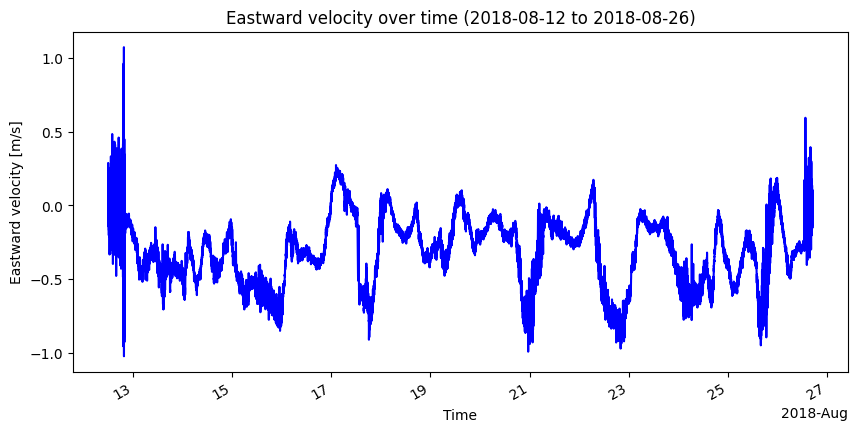

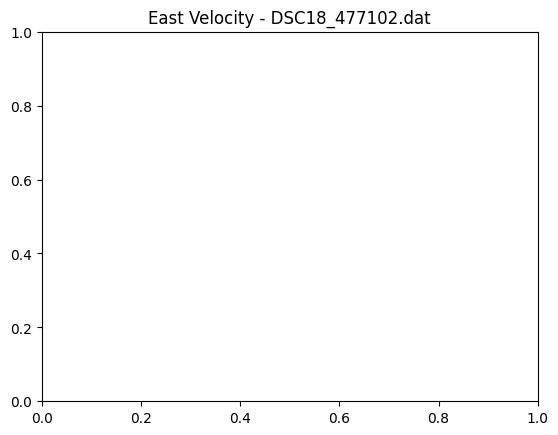

<xarray.Dataset> Size: 5MB
Dimensions:          (time: 20462)
Coordinates:
  * time             (time) datetime64[ns] 164kB 2018-08-12T12:00:00 ... 2018...
Data variables: (12/27)
    Month            (time) int64 164kB 8 8 8 8 8 8 8 8 8 ... 8 8 8 8 8 8 8 8 8
    Day              (time) int64 164kB 12 12 12 12 12 12 ... 26 26 26 26 26 26
    Year             (time) int64 164kB 2018 2018 2018 2018 ... 2018 2018 2018
    Hour             (time) int64 164kB 12 12 12 12 12 12 ... 16 16 16 17 17 17
    Minute           (time) int64 164kB 0 1 2 3 4 5 6 7 ... 55 56 57 58 59 0 1 2
    Second           (time) int64 164kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    ...               ...
    Pressure_1       (time) float64 164kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    temperature      (time) float64 164kB 19.95 19.96 19.96 ... 18.77 18.79
    Analog input 1   (time) int64 164kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    Analog input 2   (time) int64 164kB 15212 15212 15212 ... 15179 15179 15180
    Speed            (time) float64 164kB 0.18 0.288 0.091 ... 0.134 0.105 0.151
    Direction        (time) float64 164kB 38.46 89.2 16.64 ... 264.8 99.28 143.9

In [8]:
# Test reading a Nortek AquaDopp file directly
try:
    rawdir = Path(basedir) / 'moor/raw/msm76_2018/'
    instrument = 'aquadopp'
    data_dir = rawdir / instrument
    fname = 'DSC18_477102.dat'
    filename = data_dir / fname
    header_file = data_dir / (fname[:-4] + '.hdr')

    print(f"Data file: {filename}")
    print(f"Header file: {header_file}")
    print(f"Files exist: data={filename.exists()}, header={header_file.exists()}")

    if filename.exists() and header_file.exists():
        reader = NortekAsciiReader(str(filename), header_file_path=str(header_file))
        dataset = reader.get_data()

        print(f"\nDataset loaded successfully!")
        print(f"Variables: {list(dataset.data_vars)}")
        print(f"Time range: {dataset.time.min().values} to {dataset.time.max().values}")

        # Plot if east_velocity exists
        if 'east_velocity' in dataset.data_vars:
            plotter = TimeSeriesPlotter(dataset)
            plotter.plot(parameter_name='east_velocity')
            plt.title(f'East Velocity - {fname}')
            plt.show()

        # Display dataset info
        display(dataset)
    else:
        print("Files not found - skipping test")

except Exception as e:
    print(f"Error testing Nortek reader: {e}")

ADCP file: /Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/raw/msm76_2018/adcp/DS0218_RDI_000_24289.mat
File exists: True

ADCP Dataset loaded successfully!
Variables: ['east_velocity', 'north_velocity', 'up_velocity', 'depth', 'pressure', 'ensemble_number', 'heading', 'pitch', 'roll', 'heading_std', 'pitch_std', 'roll_std', 'temperature', 'salinity', 'pressure_std', 'correlation_magnitude', 'echo_intensity', 'status', 'percent_good', 'bt_range', 'bt_velocity', 'bt_correlation', 'bt_amplitude', 'bt_percent_good']
Time range: 2018-08-15T17:00:06.760004909 to 2019-08-10T18:24:06.759996189


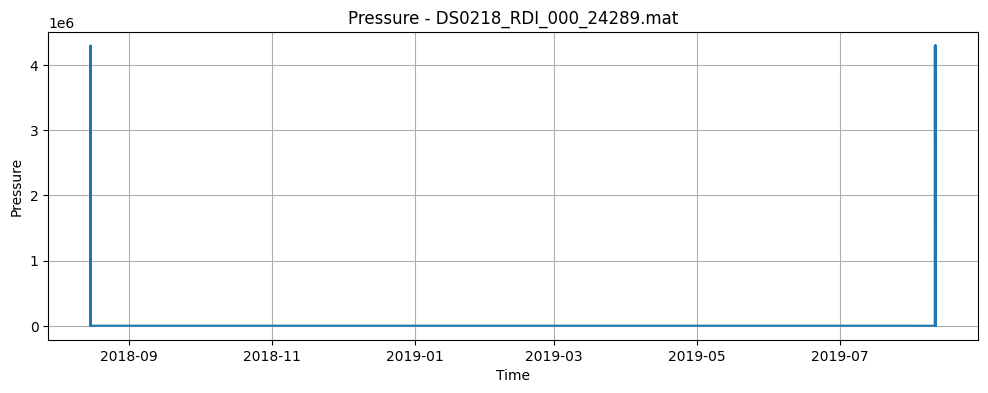

<xarray.Dataset> Size: 1GB
Dimensions:                (bin: 40, time: 172829, beam: 4)
Coordinates:
  * time                   (time) datetime64[ns] 1MB 2018-08-15T17:00:06.7600...
  * bin                    (bin) int64 320B 1 2 3 4 5 6 7 ... 35 36 37 38 39 40
    range                  (bin) float64 320B 12.17 20.17 28.17 ... 316.2 324.2
    z                      (bin, time) float64 55MB 11.17 10.17 ... 322.4 323.3
Dimensions without coordinates: beam
Data variables: (12/24)
    east_velocity          (bin, time) float64 55MB 0.002 0.015 ... nan nan
    north_velocity         (bin, time) float64 55MB 0.037 0.024 ... nan nan
    up_velocity            (bin, time) float64 55MB -0.244 -0.293 ... nan nan
    depth                  (time) float64 1MB 1.0 2.0 1.6 1.9 ... 0.8 1.8 0.9
    pressure               (time) float64 1MB 0.923 2.06 0.464 ... 1.183 0.115
    ensemble_number        (time) float64 1MB 1.0 2.0 ... 1.728e+05 1.728e+05
    ...                     ...
    percent_good           (bin, beam, time) float64 221MB 100.0 100.0 ... 0.0
    bt_range               (beam, time) float64 6MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    bt_velocity            (beam, time) float64 6MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    bt_correlation         (beam, time) float64 6MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    bt_amplitude           (beam, time) float64 6MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    bt_percent_good        (beam, time) float64 6MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes: (12/21)
    Conventions:                            CF-1.8
    title:                                  ADCP (RDI/Teledyne Workhorse) tim...
    source:                                 ADCP MATLAB export (adcp struct)
    instrument_type:                        wh-adcp
    beam_angle:                             20.0
    beam_frequency_kHz:                     150.0
    ...                                     ...
    ranges_definition:                      cell center range from transducer...
    time_coverage_start:                    2018-08-15T17:00:06.760
    time_coverage_end:                      2019-08-10T18:24:06.759
    vertical_velocity_converted_from_cm_s:  false
    pressure_original_units:                Pa
    dropped_zero_mtime_samples:             1

In [9]:
# Test reading an ADCP MATLAB file directly
try:
    rawdir = Path(basedir) / 'moor/raw/msm76_2018/'
    instrument = 'adcp'
    data_dir = rawdir / instrument
    fname = 'DS0218_RDI_000_24289.mat'
    filename = data_dir / fname

    print(f"ADCP file: {filename}")
    print(f"File exists: {filename.exists()}")

    if filename.exists():
        reader = AdcpMatlabReader(str(filename))
        dataset = reader.get_data()

        print(f"\nADCP Dataset loaded successfully!")
        print(f"Variables: {list(dataset.data_vars)}")
        print(f"Time range: {dataset.time.min().values} to {dataset.time.max().values}")

        # Plot pressure if it exists
        if 'pressure' in dataset.data_vars:
            plt.figure(figsize=(12, 4))
            plt.plot(dataset.time, dataset.pressure)
            plt.title(f'Pressure - {fname}')
            plt.xlabel('Time')
            plt.ylabel('Pressure')
            plt.grid(True)
            plt.show()

        # Display dataset info
        display(dataset)
    else:
        print("File not found - skipping test")

except Exception as e:
    print(f"Error testing ADCP reader: {e}")

## Analyzing Processed Results

Load and visualize the processed NetCDF files.


Analyzing successful mooring: dsE_1_2018
Analyzing processed files in: /Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/proc/dsE_1_2018/microcat
Found 1 NetCDF files:

📄 Loading: dsE_1_2018_7518_raw.nc
   Variables: ['temperature', 'salinity', 'conductivity', 'pressure', 'serial_number', 'InstrDepth', 'instrument', 'clock_offset', 'start_time', 'end_time']
   Attributes: ['latitude', 'longitude', 'CreateTime', 'DataType', 'mooring_name', 'waterdepth', 'deployment_latitude', 'deployment_longitude', 'deployment_time', 'seabed_latitude', 'seabed_longitude', 'recovery_time']
   Mooring: dsE_1_2018
   Instrument: microcat
   Serial: 7518


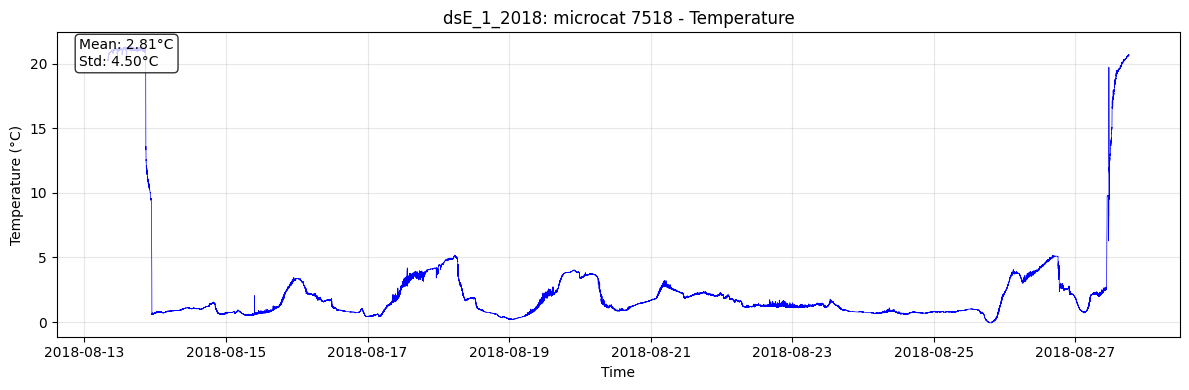

   📊 Plot saved: dsE_1_2018_microcat_7518_temperature_raw.png


In [13]:
# Analyze processed files
def analyze_processed_mooring(mooring_name, basedir, instrument_type='microcat'):
    """Analyze processed files for a specific mooring and instrument type."""
    proc_dir = Path(basedir) / 'moor/proc' / mooring_name / instrument_type
    fig_dir = proc_dir

    if not proc_dir.exists():
        print(f"Directory not found: {proc_dir}")
        return

    print(f"Analyzing processed files in: {proc_dir}")

    # Find all NetCDF files
    nc_files = list(proc_dir.glob('*raw.nc'))
    if not nc_files:
        print("No NetCDF files found")
        return

    print(f"Found {len(nc_files)} NetCDF files:")

    for file_path in nc_files:
        try:
            print(f"\n📄 Loading: {file_path.name}")

            with xr.open_dataset(file_path) as dataset:
                print(f"   Variables: {list(dataset.data_vars)}")
                print(f"   Attributes: {list(dataset.attrs.keys())}")

                # Extract key metadata
                mooring_name_attr = dataset.attrs.get('mooring_name', 'Unknown')
                instrument_name = dataset.get('instrument', 'Unknown').values if 'instrument' in dataset else 'Unknown'
                serial_number = dataset.get('serial_number', 0).values if 'serial_number' in dataset else 0

                print(f"   Mooring: {mooring_name_attr}")
                print(f"   Instrument: {instrument_name}")
                print(f"   Serial: {serial_number}")

                # Plot temperature if available
                if 'temperature' in dataset.data_vars:
                    fig, ax = plt.subplots(figsize=(12, 4))
                    ax.plot(dataset['time'], dataset['temperature'], 'b-', linewidth=0.5)
                    ax.set_ylabel('Temperature (°C)')
                    ax.set_title(f'{mooring_name_attr}: {instrument_name} {serial_number} - Temperature')
                    ax.set_xlabel('Time')
                    ax.grid(True, alpha=0.3)

                    # Add stats
                    temp_mean = dataset['temperature'].mean().values
                    temp_std = dataset['temperature'].std().values
                    ax.text(0.02, 0.98, f'Mean: {temp_mean:.2f}°C\nStd: {temp_std:.2f}°C',
                           transform=ax.transAxes, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

                    plt.tight_layout()
                    plt.show()

                    # Save plot
                    plot_name = f"{mooring_name_attr}_{instrument_name}_{serial_number}_temperature_raw.png"
                    fig.savefig(fig_dir / plot_name, dpi=150, bbox_inches='tight')
                    print(f"   📊 Plot saved: {plot_name}")

        except Exception as e:
            print(f"   ❌ Error loading {file_path.name}: {e}")

# Example usage
if results and any(results.values()):
    # Analyze the first successfully processed mooring
    successful_mooring = next(mooring for mooring, success in results.items() if success)
    print(f"\nAnalyzing successful mooring: {successful_mooring}")
    analyze_processed_mooring(successful_mooring, basedir, 'microcat')
else:
    print("No successfully processed moorings to analyze")